In [1]:
import pandas as pd
import numpy as np

# experiment list
norms_list = ['normal','MinMax', 'BN', 'LN', 'IN', 'RevIN']
dataset_list = ['etth1', 'etth2', 'ettm1', 'ettm2']
model_list = ['lstm', 'SCINet', 'Informer']

# default setup
seq_len = 128
pred_len = 32
stride = 4
dist = 0

# dataset
from src.config import Config
from src.dataset import CustomDataset
from src.utils import split_data
from src.feature_extraction import time_features

config = Config()

data = pd.read_csv(config.DATA_PATH["etth1"])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
ts_train, ts_valid, ts_test = split_data(data, 0.6, 0.2)
    
train_data = CustomDataset(ts_train, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)
valid_data = CustomDataset(ts_valid, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)
test_data = CustomDataset(ts_test, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)


/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [129]:
from typing import Literal
import torch, os
from src.seq2seq import SimpleRNN
from src.SCINet.model import SCINet
from src.Informer.model import Informer
from src.scaler import Wrapper
import warnings

warnings.filterwarnings("ignore")

def load_model(
    model_type : Literal['lstm','SCINet','Informer'], 
    norms_type : Literal['normal', 'MinMax', 'BN', 'LN', 'IN', 'RevIN'],
    dataset : Literal['etth1', 'etth2', 'ettm1', 'ettm2'],
    seq_len : int = 128,
    pred_len : int = 32,
    dist : int = 0
    ):

    tag = "{}_seq_{}_pred_{}_dist_{}_scaler_{}_{}".format(model_type, seq_len, pred_len, dist, norms_type, dataset)
    save_best_dir = "./weights/{}_best.pt".format(tag)
    
    if model_type == 'lstm':
        network = SimpleRNN(
            input_dim = len(config.src_cols),
            hidden_dim = 128,
            output_dim = len(config.tar_cols),
            n_layers = 1,
            target_len = pred_len,
            teacher_forcing_ratio=0.6
        )
        gpu_num = 0
        num_features = len(config.src_cols)
        
    elif model_type == 'SCINet':
        network = SCINet(
            pred_len,
            seq_len,
            len(config.src_cols),
            1,
            1,
            3,
            1,
            0,
            1,
            3,
            0.5,
            0
        )
        gpu_num = 1
        num_features = len(config.src_cols)
        
    elif model_type == 'Informer':
        network = Informer(
            len(config.src_cols),
            len(config.src_cols),
            len(config.t_feature_cols + config.tar_cols),
            seq_len,
            pred_len,
            pred_len,
            4,
            128,
            4,
            2,
            1,
            128,
            0.5,
            'prob',
            'timeF',
            t_input_dim=len(config.t_feature_cols)
        )
        gpu_num = 2
        
        num_features = len(config.t_feature_cols + config.src_cols)
        
    if norms_type == 'normal':
        args_scaler = {}
        
    elif norms_type == 'MinMax':
        args_scaler = {            
            "num_features" : num_features,
            "eps" : 1e-6
        }
    elif norms_type == 'BN':
        args_scaler = {            
            "num_features" : num_features,
            "eps" : 1e-6,
            "momentum" : 0.1,
            "affine" : True,
            "track_running_stats" : True
        }
    elif norms_type == 'IN':
        args_scaler = {            
            "num_features" : num_features,
            "eps" : 1e-6,
            "momentum" : 0.1,
            "affine" : True,
            "track_running_stats" : True
        }
    elif norms_type == 'LN':
        args_scaler = {            
            "num_features" : num_features,
            "eps" : 1e-6,
            "gamma":True, 
            "beta":True
        }
    elif norms_type == 'RevIN':
        args_scaler = {
            "num_features" : num_features,
            "eps" : 1e-6,
            "affine" : True
        }
        
    # torch cuda initialize and clear cache
    torch.cuda.init()
    torch.cuda.empty_cache()
    
    # device allocation
    if(torch.cuda.device_count() >= 1):
        device = "cuda:" + str(gpu_num)
    else:
        device = 'cpu'

    model = Wrapper(
        network,
        norms_type,
        **args_scaler
    )
    
    model.load_state_dict(torch.load(os.path.join("./weights", "{}_best.pt".format(tag))))
    model.to(device)
    
    return model, device

In [133]:
from src.utils import compute_metrics
from src.train import evaluate
from torch.utils.data import DataLoader

exp = pd.DataFrame({
    "mse":[],
    "rmse":[],
    "mae":[],
    "r2":[],
    "model":[],
    "dataset":[],
    "norm":[],
    "seq_len":[],
    "pred_len" :[]
})

# setting
seq_len = 128
pred_len = 96
stride = 4
dist = 0

# analysis
for model_type in model_list:
    for dataset in dataset_list:
        for norms in norms_list:
            data = pd.read_csv(config.DATA_PATH[dataset])
            data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
            _, _, ts_test = split_data(data, 0.6, 0.2)
            
            if model_type == 'Informer':
                test_data = CustomDataset(ts_test, config.t_feature_cols + config.src_cols, config.t_feature_cols + config.tar_cols, seq_len, pred_len, stride = stride)
            else:
                test_data = CustomDataset(ts_test, config.src_cols, config.tar_cols, seq_len, pred_len, stride = stride)
                   
            test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
         
            model, device = load_model(model_type, norms, dataset, seq_len, pred_len)
            
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
            loss_fn = torch.nn.MSELoss(reduction='mean')
    
            test_loss, mse, rmse, mae, r2 = evaluate(
                test_loader,
                model,
                model_type.lower(),
                optimizer,
                loss_fn,
                device, 
            )
            
            result = pd.DataFrame({
                "mse":[mse],
                "rmse":[rmse],
                "mae":[mae],
                "r2":[r2],
                "model":[model_type],
                "dataset":[dataset],
                "norm":[norms],
                "seq_len":[seq_len],
                "pred_len" :[pred_len]
            })
            exp = exp.append(result)
            
            model.cpu()
            del model
            del test_loader
            del test_data

test loss : 17.458
# mse:13.619, rmse:3.690, mae:2.840, r2:-0.197
test loss : 26.011
# mse:16.799, rmse:4.099, mae:3.325, r2:-0.477
test loss : 24.129
# mse:11.211, rmse:3.348, mae:2.803, r2:0.014
test loss : 39.423
# mse:37.623, rmse:6.134, mae:4.832, r2:-2.307
test loss : 25.974
# mse:12.056, rmse:3.472, mae:2.853, r2:-0.060
test loss : 21.340
# mse:13.705, rmse:3.702, mae:2.913, r2:-0.205
test loss : 58.358
# mse:92.903, rmse:9.639, mae:7.867, r2:0.067
test loss : 39.264
# mse:60.135, rmse:7.755, mae:6.288, r2:0.396
test loss : 60.607
# mse:100.996, rmse:10.050, mae:8.453, r2:-0.014
test loss : 2376.361
# mse:1862.445, rmse:43.156, mae:32.592, r2:-17.694
test loss : 57.853
# mse:100.850, rmse:10.042, mae:8.266, r2:-0.012
test loss : 18.488
# mse:53.753, rmse:7.332, mae:5.850, r2:0.460
test loss : 16.139
# mse:9.896, rmse:3.146, mae:2.380, r2:0.157
test loss : 27.292
# mse:24.127, rmse:4.912, mae:4.186, r2:-1.055
test loss : 24.623
# mse:13.249, rmse:3.640, mae:2.914, r2:-0.129
test 

In [134]:
exp.to_csv("./results/experiment.csv")

In [5]:
# For etth1 dataset
exp[exp.dataset == 'etth1']

,mse,rmse,mae,r2,model,dataset,norm,seq_len,pred_len
0,15.732444,3.966414,3.181859,-0.383662,lstm,etth1,normal,128.0,32.0
0,10.775748,3.282644,2.649242,0.052278,lstm,etth1,MinMax,128.0,32.0
0,10.468357,3.235484,2.578566,0.079313,lstm,etth1,BN,128.0,32.0
0,12.899261,3.591554,2.797258,-0.134484,lstm,etth1,LN,128.0,32.0
0,22.240063,4.715937,3.766203,-0.956004,lstm,etth1,IN,128.0,32.0
0,5.474803,2.339830,1.794869,0.518493,lstm,etth1,RevIN,128.0,32.0
0,4.463019,2.112586,1.644694,0.607479,SCINet,etth1,normal,128.0,32.0
0,5.292237,2.300486,1.812300,0.534550,SCINet,etth1,MinMax,128.0,32.0
0,6.026779,2.454950,1.937655,0.469947,SCINet,etth1,BN,128.0,32.0
0,27.863804,5.278617,4.134959,-1.450609,SCINet,etth1,LN,128.0,32.0


In [6]:
exp[exp.dataset == 'ettm1']

,mse,rmse,mae,r2,model,dataset,norm,seq_len,pred_len
0,5.010833,2.238489,1.664665,0.574971,lstm,ettm1,normal,128.0,32.0
0,6.207355,2.491457,1.918350,0.473479,lstm,ettm1,MinMax,128.0,32.0
0,7.253613,2.693253,2.002347,0.384734,lstm,ettm1,BN,128.0,32.0
0,7.575601,2.752381,2.097854,0.357422,lstm,ettm1,LN,128.0,32.0
0,19.280157,4.390918,3.538696,-0.635382,lstm,ettm1,IN,128.0,32.0
0,2.024698,1.422919,0.982256,0.828261,lstm,ettm1,RevIN,128.0,32.0
0,2.262757,1.504246,1.063686,0.808068,SCINet,ettm1,normal,128.0,32.0
0,2.191860,1.480493,1.056039,0.814082,SCINet,ettm1,MinMax,128.0,32.0
0,1.723411,1.312788,0.930868,0.853817,SCINet,ettm1,BN,128.0,32.0
0,11.643626,3.412276,2.756048,0.012364,SCINet,ettm1,LN,128.0,32.0


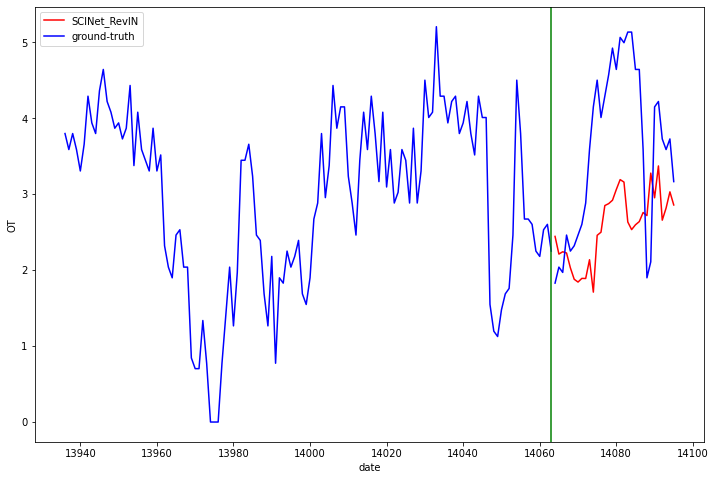

In [6]:
# plot the trend
model_type = 'SCINet'
norms_type = 'RevIN'
dataset = 'ettm2'

model, device = load_model(model_type, norms_type, dataset)

input_len = 128
output_len = 32
col_idx = -1
idx_srt = 0
idx_end = idx_srt + input_len

# src_cols = config.t_feature_cols + config.src_cols
src_cols = config.src_cols
# tar_cols = config.t_feature_cols + config.tar_cols
tar_cols = config.tar_cols

tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

model.to(device)
model.eval()
pred_normal = model.predict(test_input, output_len).squeeze(0)
model.cpu()

import matplotlib.pyplot as plt

plt.figure(1, figsize = (12,8))
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])

plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g')
plt.plot(tx_output, pred_normal[:,col_idx].cpu().numpy(), c = 'r', label = "{}_{}".format(model_type, norms_type))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend()
plt.show()

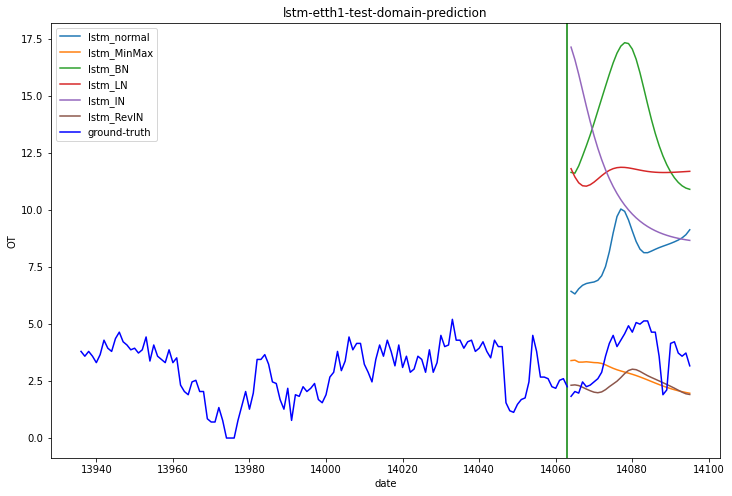

In [7]:
# model performace, LSTM seq2seq
model_type = 'lstm'
dataset = 'etth1'

plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    src_cols = config.t_feature_cols + config.src_cols
    # src_cols = config.src_cols
    tar_cols = config.t_feature_cols + config.tar_cols
    # tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    model.eval()
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

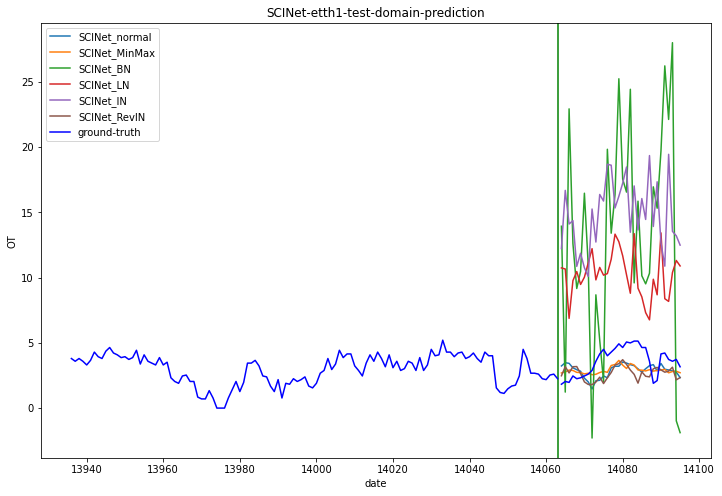

In [8]:
# model performace, SCINet
model_type = 'SCINet'
dataset = 'etth1'

plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    # src_cols = config.t_feature_cols + config.src_cols
    src_cols = config.src_cols
    # tar_cols = config.t_feature_cols + config.tar_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    model.eval()
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

In [ ]:
# model performace, LSTM seq2seq
model_type = 'lstm'
dataset = 'etth1'

plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    src_cols = config.src_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()
    
    

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()

In [26]:
# model performace, LSTM seq2seq
from torch.utils.data import DataLoader
from src.utils import compute_metrics
from src.train import evaluate

model_type = 'lstm'
dataset = 'etth1'
seq_len = 128

exp_pred_len = {
    "r2":[],
    "mse":[],
    "rmse":[],
    "mae":[],
    "pred_len":[],
    'norms':[]
}

for pred_len in [16, 32, 64, 96, 128]:
    for norms_type in norms_list:
        
        data = pd.read_csv(config.DATA_PATH[dataset])
        data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
        _,_,ts_test = split_data(data, 0.6, 0.2)
        
        src_cols = config.src_cols
        tar_cols = config.tar_cols
        
        test_data = CustomDataset(ts_test, src_cols, tar_cols, seq_len, pred_len, stride = stride)
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
        
        test_loss, mse, rmse, mae, r2 = evaluate(
            test_loader,
            model,
            'lstm',
            optimizer,
            loss_fn,
            device, 
        )
        
        exp_pred_len['r2'].append(r2)
        exp_pred_len['mse'].append(mse)
        exp_pred_len['rmse'].append(rmse)
        exp_pred_len['mae'].append(mae)
        exp_pred_len['pred_len'].append(pred_len)
        exp_pred_len['norms'].append(norms_type)
        
exp_pred_len = pd.DataFrame(exp_pred_len)

test loss : 14.146
# mse:7.392, rmse:2.719, mae:2.094, r2:0.350
test loss : 23.232
# mse:6.835, rmse:2.614, mae:2.105, r2:0.399
test loss : 20.834
# mse:9.216, rmse:3.036, mae:2.449, r2:0.189
test loss : 42.296
# mse:35.163, rmse:5.930, mae:4.748, r2:-2.093
test loss : 23.732
# mse:15.465, rmse:3.933, mae:3.149, r2:-0.361
test loss : 10.523
# mse:4.765, rmse:2.183, mae:1.701, r2:0.581
test loss : 14.699
# mse:9.559, rmse:3.092, mae:2.381, r2:0.159
test loss : 24.434
# mse:10.736, rmse:3.277, mae:2.631, r2:0.056
test loss : 22.983
# mse:10.219, rmse:3.197, mae:2.634, r2:0.101
test loss : 39.012
# mse:33.868, rmse:5.820, mae:4.620, r2:-1.979
test loss : 24.826
# mse:13.399, rmse:3.660, mae:2.927, r2:-0.178
test loss : 13.293
# mse:7.475, rmse:2.734, mae:2.166, r2:0.343
test loss : 16.778
# mse:12.120, rmse:3.481, mae:2.691, r2:-0.067
test loss : 25.618
# mse:14.938, rmse:3.865, mae:3.124, r2:-0.315
test loss : 23.938
# mse:10.944, rmse:3.308, mae:2.759, r2:0.036
test loss : 39.341
# mse:

In [27]:
exp_pred_len[exp_pred_len['norms'] == 'RevIN']

,r2,mse,rmse,mae,pred_len,norms
5,0.580815,4.764800,2.182842,1.701271,16,RevIN
11,0.342552,7.475283,2.734096,2.165641,32,RevIN
17,0.014966,11.188836,3.344972,2.644949,64,RevIN
23,-0.204772,13.705498,3.702094,2.912602,96,RevIN
29,-0.371295,15.602152,3.949956,3.117388,128,RevIN


In [28]:
exp_pred_len[exp_pred_len['norms'] == 'normal']

,r2,mse,rmse,mae,pred_len,norms
0,0.349673,7.392158,2.718852,2.094278,16,normal
6,0.159329,9.558556,3.091691,2.380732,32,normal
12,-0.067038,12.120308,3.481423,2.690572,64,normal
18,-0.197196,13.619315,3.690436,2.840464,96,normal
24,-0.285248,14.623132,3.824020,2.934741,128,normal


In [29]:
exp_pred_len[exp_pred_len['norms'] == 'MinMax']

,r2,mse,rmse,mae,pred_len,norms
1,0.398693,6.834953,2.614374,2.105331,16,MinMax
7,0.055732,10.736468,3.276655,2.631135,32,MinMax
13,-0.315099,14.937989,3.864969,3.123650,64,MinMax
19,-0.476723,16.799217,4.098685,3.324812,96,MinMax
25,-0.570563,17.869350,4.227215,3.438821,128,MinMax


In [30]:
exp_pred_len[exp_pred_len['norms'] == 'BN']

,r2,mse,rmse,mae,pred_len,norms
2,0.189179,9.216458,3.035862,2.448977,16,BN
8,0.101216,10.219312,3.196766,2.633636,32,BN
14,0.036484,10.944414,3.308234,2.758805,64,BN
20,0.014465,11.211451,3.348351,2.803108,96,BN
26,0.002330,11.351170,3.369150,2.825933,128,BN


In [31]:
exp_pred_len[exp_pred_len['norms'] == 'LN']

,r2,mse,rmse,mae,pred_len,norms
3,-2.093448,35.162678,5.929812,4.747753,16,LN
9,-1.978715,33.868446,5.819660,4.620343,32,LN
15,-2.146213,35.737312,5.978069,4.718379,64,LN
21,-2.307224,37.623013,6.133760,4.832326,96,LN
27,-2.386450,38.529922,6.207248,4.899298,128,LN


In [33]:
# model performace, LSTM seq2seq
from torch.utils.data import DataLoader
from src.utils import compute_metrics
from src.train import evaluate

model_type = 'lstm'
dataset = 'etth2'
seq_len = 128

exp_pred_len = {
    "r2":[],
    "mse":[],
    "rmse":[],
    "mae":[],
    "pred_len":[],
    'norms':[]
}

for pred_len in [16, 32, 64, 96, 128]:
    for norms_type in norms_list:
        
        data = pd.read_csv(config.DATA_PATH[dataset])
        data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
        _,_,ts_test = split_data(data, 0.6, 0.2)
        
        src_cols = config.src_cols
        tar_cols = config.tar_cols
        
        test_data = CustomDataset(ts_test, src_cols, tar_cols, seq_len, pred_len, stride = stride)
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = True,  num_workers = 8, pin_memory=False)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
        
        test_loss, mse, rmse, mae, r2 = evaluate(
            test_loader,
            model,
            'lstm',
            optimizer,
            loss_fn,
            device, 
        )
        
        exp_pred_len['r2'].append(r2)
        exp_pred_len['mse'].append(mse)
        exp_pred_len['rmse'].append(rmse)
        exp_pred_len['mae'].append(mae)
        exp_pred_len['pred_len'].append(pred_len)
        exp_pred_len['norms'].append(norms_type)
        
exp_pred_len = pd.DataFrame(exp_pred_len)

test loss : 59.468
# mse:97.555, rmse:9.877, mae:8.013, r2:0.055
test loss : 42.414
# mse:62.002, rmse:7.874, mae:6.368, r2:0.399
test loss : 60.068
# mse:105.485, rmse:10.271, mae:8.577, r2:-0.022
test loss : 2345.165
# mse:1854.499, rmse:43.064, mae:32.832, r2:-16.971
test loss : 60.496
# mse:102.952, rmse:10.147, mae:8.341, r2:0.002
test loss : 15.251
# mse:43.755, rmse:6.615, mae:5.187, r2:0.576
test loss : 60.072
# mse:96.544, rmse:9.826, mae:7.977, r2:0.055
test loss : 40.694
# mse:59.035, rmse:7.683, mae:6.201, r2:0.422
test loss : 60.795
# mse:103.930, rmse:10.195, mae:8.553, r2:-0.017
test loss : 2355.309
# mse:1873.999, rmse:43.290, mae:32.944, r2:-17.334
test loss : 59.592
# mse:102.943, rmse:10.146, mae:8.347, r2:-0.007
test loss : 16.590
# mse:46.624, rmse:6.828, mae:5.379, r2:0.544
test loss : 58.834
# mse:94.113, rmse:9.701, mae:7.899, r2:0.064
test loss : 39.460
# mse:59.173, rmse:7.692, mae:6.226, r2:0.411
test loss : 61.043
# mse:101.928, rmse:10.096, mae:8.491, r2:-0

In [34]:
exp_pred_len[exp_pred_len['norms'] == 'BN']

,r2,mse,rmse,mae,pred_len,norms
2,-0.022213,105.484749,10.270576,8.577396,16,BN
8,-0.016799,103.929520,10.194583,8.552792,32,BN
14,-0.014192,101.928375,10.095959,8.490543,64,BN
20,-0.013753,100.996468,10.049700,8.453195,96,BN
26,-0.014249,100.335678,10.016769,8.426069,128,BN


In [35]:
exp_pred_len[exp_pred_len['norms'] == 'RevIN']

,r2,mse,rmse,mae,pred_len,norms
5,0.575986,43.755062,6.614761,5.187218,16,RevIN
11,0.543856,46.623619,6.828149,5.379117,32,RevIN
17,0.491262,51.129250,7.150472,5.678169,64,RevIN
23,0.460452,53.753170,7.331656,5.850440,96,RevIN
29,0.443662,55.036327,7.418647,5.920354,128,RevIN


In [36]:
exp_pred_len[exp_pred_len['norms'] == 'normal']

,r2,mse,rmse,mae,pred_len,norms
0,0.054629,97.555283,9.877007,8.013186,16,normal
6,0.055454,96.544327,9.825697,7.976964,32,normal
12,0.063576,94.112526,9.701161,7.899107,64,normal
18,0.067487,92.902847,9.638613,7.867424,96,normal
24,0.065411,92.455238,9.615365,7.859456,128,normal


In [63]:
# data shift issue
data = pd.read_csv(config.DATA_PATH["etth1"])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
ts_train, ts_valid, ts_test = split_data(data, 0.6, 0.2)

In [64]:
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.6:
        tag_list.append("train")
    elif idx<= len(data) * 0.8:
        tag_list.append("valid")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

<AxesSubplot:xlabel='OT', ylabel='Density'>

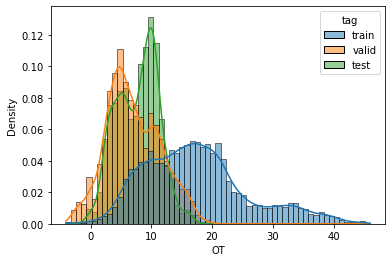

In [65]:
import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

<AxesSubplot:xlabel='OT', ylabel='Density'>

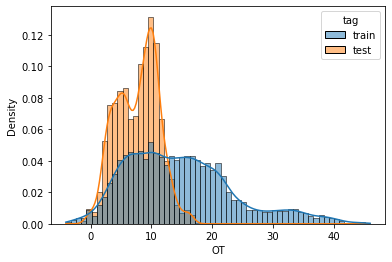

In [125]:
# data shift issue
data = pd.read_csv(config.DATA_PATH["etth1"])
data[config.t_feature_cols] = time_features(data, timeenc = 1, freq = 'h')
ts_train, ts_valid, ts_test = split_data(data, 0.6, 0.2)

tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

In [126]:
model_type = 'lstm'
norms_type = 'RevIN'
dataset = 'etth1'
seq_len = 128

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

<AxesSubplot:xlabel='OT', ylabel='Density'>

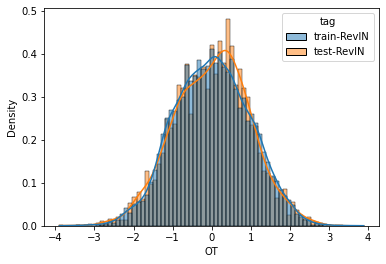

In [127]:
sns.histplot(data = data[(data['tag'] == 'train-RevIN') | (data['tag'] == 'test-RevIN' )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

<AxesSubplot:xlabel='OT', ylabel='Density'>

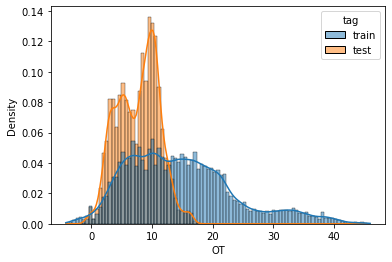

In [115]:
# data shift issue
data = pd.read_csv(config.DATA_PATH["ettm1"])[config.src_cols]
tag_list = []

for idx in range(len(data)):
    if idx <= len(data) * 0.8:
        tag_list.append("train")
    else:
        tag_list.append("test")
        
data['tag'] = tag_list

import seaborn as sns

sns.histplot(data = data, x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

In [116]:
model_type = 'lstm'
norms_type = 'RevIN'
dataset = 'ettm1'
seq_len = 128

model, device = load_model(model_type, norms_type, dataset, seq_len, 96)
model.cpu()

Wrapper(
  (model): SimpleRNN(
    (encoder): RnnEncoder(
      (lstm): LSTM(7, 128, bidirectional=True)
    )
    (decoder): RnnDecoder(
      (lstm): LSTM(7, 128, bidirectional=True)
      (mlp): Linear(in_features=256, out_features=7, bias=True)
    )
  )
  (scaler): RevIN()
)

In [121]:
class TempDataset(torch.utils.data.Dataset):
    def __init__(self, data:np.ndarray, seq_len : int):
        self.data = data
        self.seq_len = seq_len
        self.indices = range(0,len(data) - seq_len, seq_len)
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx:int):
        indx = self.indices[idx]
        data = self.data[indx : indx + self.seq_len, :]
        return torch.from_numpy(data)
    
# train set
norm_dataset = TempDataset(data[data['tag'] == 'train'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['train-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

# test set
norm_dataset = TempDataset(data[data['tag'] == 'test'][config.src_cols].values, seq_len)
dataloader = torch.utils.data.DataLoader(norm_dataset, batch_size=128, shuffle=False)

data_normalized = []

for x in dataloader:
    norm = model.scaler(x, 'norm').detach()
    data_normalized.append(norm)

data_normalized = torch.concat(data_normalized, dim = 0).view(-1, len(config.src_cols)).cpu().numpy()

temp = pd.DataFrame(data_normalized, columns = config.src_cols)
temp['tag'] = ['test-RevIN' for _ in range(len(temp))]
data = data.append(temp)
data = data.reset_index(drop = True)

<AxesSubplot:xlabel='OT', ylabel='Density'>

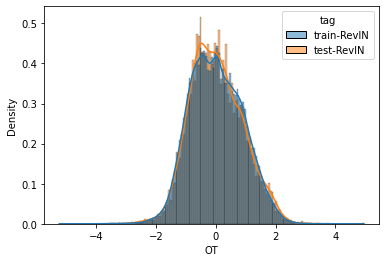

In [123]:
sns.histplot(data = data[(data['tag'] == 'train-RevIN') | (data['tag'] == 'test-RevIN' )], x = 'OT', hue = 'tag', kde = True, stat = 'density', discrete = False, common_norm = False)

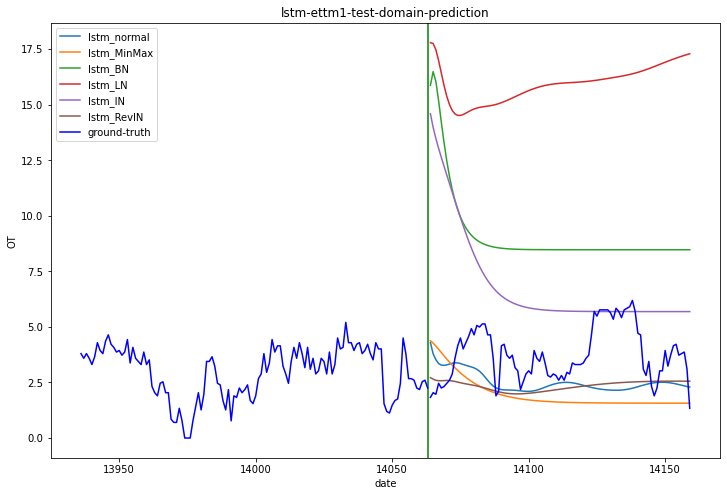

In [131]:
# Forecasting experiment
model_type = 'lstm'
dataset = 'ettm1'
seq_len = 128
pred_len = 96

plt.figure(1, figsize = (12,8))

for norms_type in norms_list:
    model, device = load_model(model_type, norms_type, dataset, seq_len, pred_len)
    input_len = seq_len
    output_len = pred_len
    col_idx = -1
    idx_srt = 0
    idx_end = idx_srt + input_len

    # src_cols = config.t_feature_cols + config.src_cols
    src_cols = config.src_cols
    # tar_cols = config.t_feature_cols + config.tar_cols
    tar_cols = config.tar_cols

    tx_input = ts_test['date'].iloc[idx_srt:idx_end].index
    tx_output = ts_test['date'].iloc[idx_end:idx_end+output_len].index

    true_output = ts_test[tar_cols].iloc[idx_end:idx_end+output_len].values

    test_input = ts_test[src_cols].iloc[idx_srt : idx_end].values
    test_input = torch.from_numpy(test_input).float().to(device).unsqueeze(0)

    model.to(device)
    model.eval()
    pred = model.predict(test_input, output_len).squeeze(0)
    model.cpu()

    import matplotlib.pyplot as plt

    plt.plot(tx_output, pred[:,col_idx].cpu().numpy(), label = "{}_{}".format(model_type, norms_type))
   
plt.axvline(x = tx_input[-1], ymin = 0, ymax = 1, c = 'g') 
plt.plot(tx_input, ts_test[src_cols[col_idx]].iloc[idx_srt : idx_end], c = 'b')
plt.xlabel("date")
plt.ylabel(config.tar_cols[col_idx])
plt.title("{}-{}-test-domain-prediction".format(model_type, dataset))
plt.plot(tx_output, true_output[:,col_idx], c = 'b', label = 'ground-truth')
plt.legend() 
plt.show()